One of the most basic machine learning algorithms is going to be quite familiar to everyone, and it's known as linear regression.  Regression (as opposed to classification) is the process of predicting a *real* valued output based on some input parameters.  Let's look at a problem that we might apply linear regression to.  Imagine that you work for UNICEF or some other multinational non-profit, and you want to know the infant mortality rate for the nation of Hungary.  However, let's imagine that that information has never been collected.  What we want to do then is to identify some proxy that might be related, for example per capita income, and make a prediction based on that.  Of course, we'll need to do some machine learning based on some other countries where we do know both PCI and infant mortality in order to make better predictions.

Such a dataset does exist, and I downloaded it from http://www.stat.ufl.edu/~winner/datasets.html, which has a ton of great datasets.  We can load them using pandas, which we import here:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [12,8]

The data is in a text format with spaces as delimiters.  Pandas has a nice parsing utility that we can use to read the file

In [2]:
data = pd.read_csv('birthrate.dat',header=0,sep=r"\s{2,}",engine='python',index_col=0)
test_set = data.loc['Hungary']
data = data.drop('Hungary')

Notice that this dataset does actually include Hungary, but I've split it from the training set for instructional purposes.    

Let's have a look at what we just imported.  The Jupyter notebook has support for pandas data objects, which means they'll print nicely if we just say...

In [3]:
data

,Birth Rate,PCI,Farm Pop,Infant Mortality
Country,,,,
Venezuela,46.4,392,0.40,68.5
Mexico,45.7,118,0.61,87.8
Ecuador,45.3,44,0.53,115.8
Colombia,38.6,158,0.53,106.8
Ceylon,37.2,81,0.53,71.6
Puerto Rico,35.0,374,0.37,60.2
Chile,34.0,187,0.30,118.7
Canada,28.3,993,0.19,33.7
United States,24.7,1723,0.12,27.2


Now that we have the data table, let's use matplotlib to plot per capita income against infant morality

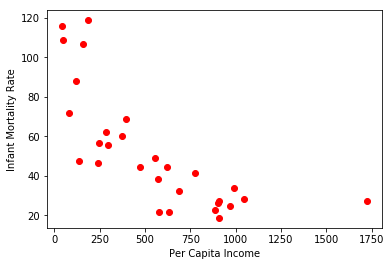

In [4]:
plt.plot(data['PCI'],data['Infant Mortality'],'ro')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()

That weird point out to the right is kind of screwing things up, so let's drop it manually.

In [5]:
data = data.drop('United States')

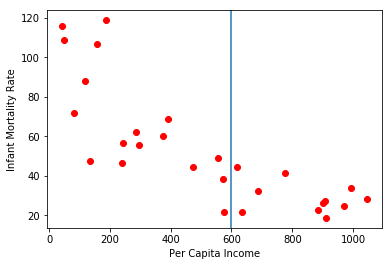

In [6]:
plt.plot(data['PCI'],data['Infant Mortality'],'ro')
plt.axvline([600])
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()


There's a clear, but noisy trend here.  Let's see if we can model these data.  Note once again that what we're doing now is slightly different from classification: rather than using features to predict a discrete value (the class), we're trying to predict a real value (infant mortality rate).  

However, mostly the mechanics are the same.  So how to proceed?  First, we need to come up with a model for the data.  A common assumption for data in general when you don't have any better ideas is to assume that for a given attribute the data are normally distributed.  This is to say that if we picked PCI of 600, simulated countries with that PCI, and then recorded their mortality rate, that the mortality rate would follow a bell curve.  This is to say, that if we had access to infinite numbers of countries with PCI of 600, the histogram of infant mortality rates would look like this:


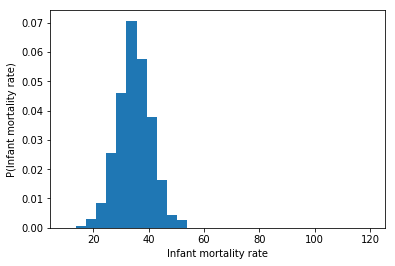

In [7]:
mu_600 = 35.
sigma = 6

plt.hist(np.random.randn(1000)*sigma + mu_600,np.linspace(10,120,31),density=True)
plt.xlabel('Infant mortality rate')
plt.ylabel('P(Infant mortality rate)')
plt.show()

However, we don't have enough data to learn the parameters for every possible value of PCI (of which there are infinite because it's real valued), so instead, we're going to parameterize the parameter, and say that the mean of the normal distribution follows some function.  Let's call the mean $\mu(x)$, where $x$ is shorthand for the PCI.  <font color=red>What's a reasonable function for $\mu(x)$?</font>  

Now that we have *parameterized our parameter*, we can write down the likelihood function for the data.
$$
\underbrace{P(\mathbf{y}|\mathbf{x})}_{\mathrm{likelihood}} = \prod_{i=1}^m N(y_i|\mu(x_i),\Sigma).
$$
Let's assume that the covariance matrix is actually just a scalar $\sigma^2$, which is to say that all the points have the same amount of uncertainty, and they're all independent of one another.  
$$
\underbrace{P(\mathbf{y}|\mathbf{x})}_{\mathrm{likelihood}} = \prod_{i=1}^m N(y_i|\mu(x_i),\sigma^2).
$$
Now, if we want to fit this model to the data (i.e. find the values of the parameters of $\mu(x)$), we can do what we've done in previous cases and find the maximum likelihood solution.  As before, it's easiest to take the logarithm first to make things easier:
$$
\ln P(\mathbf{y}|\mathbf{x},w_0,w_1,\sigma^2) \propto \sum_{i=1}^m \frac{1}{2 \sigma^2} (y_i - \mu(x))^2
$$
Of course we can find the minimum to this by taking derivatives and setting equal to zero, but let's first just search all possible parameter values.

/home/brinkerhoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/brinkerhoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


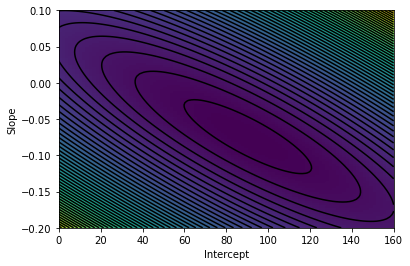

In [8]:
x = data['PCI'].as_matrix().astype(float)
y = data['Infant Mortality'].as_matrix().astype(float)

w0_sweep = np.linspace(0,160,100)
w1_sweep = np.linspace(0.1,-0.2,100)

W0_grid,W1_grid = np.meshgrid(w0_sweep,w1_sweep)
cost_list = np.zeros_like(W0_grid)

for i,w1 in enumerate(w1_sweep):
    for j,w0 in enumerate(w0_sweep):
        cost = 0.5*np.dot(y - (w1*x + w0),y - (w1*x + w0))
        cost_list[i,j] = cost

plt.pcolor(W0_grid,W1_grid,cost_list)
plt.contour(W0_grid,W1_grid,cost_list,50,colors='k')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

So we can look and see that the slope is slightly negative (around -0.08), and the intercept is something like 95.  Of course this isn't really a viable approach for larger scale problems, so we need to figure out the max-like solution.  

We can compute the derivatives directly for this problem:
$$ \frac{\partial I}{\partial w_0} = - \sum_{i=1}^m (y_i - w_1 x_i - w_0) 1$$
$$ \frac{\partial I}{\partial w_1} = - \sum_{i=1}^m (y_i - w_1 x_i - w_0)x_i $$
Setting these equal to zeros provides the two equations
$$ \sum_{i=1}^m (y_i 1) = \sum_{i=1}^n w_1 x_i + \sum_{i=1}^n w_0 1 $$.
$$ \sum_{i=1}^m (y_i x_i) = \sum_{i=1}^n w_1 x_i^2 + \sum_{i=1}^n w_0 x_i $$
This can be written more succinctly in matrix form as
$$ X^T X W = X^T y, $$
where $W = [w_0,w_1]^T$ and 
$$ X = \left[ \begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_n \end{array} \right]. $$ 
$X^T X$ is a 2 by 2 matrix, and $X^T y$ is 2 by 1 vector, and we can easily solve this equation for $W$ using any technique for solving systems of linear equations.

In [9]:
X = np.column_stack([np.ones_like(x),x])
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))
print(np.dot(X.T,X))
print(np.dot(X.T,y))
print(w)

[[2.800000e+01 1.410100e+04]
 [1.410100e+04 9.992689e+06]]
[  1482.3 531817.4]
[ 9.03318740e+01 -7.42495194e-02]


Let's see how this value of $w_0$ and $w_1$ compares to our error surface that we computed above 

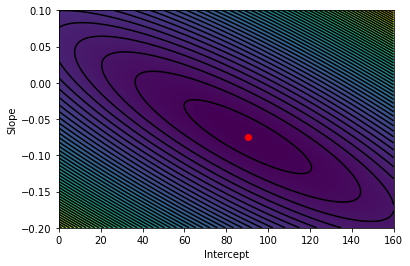

In [10]:
plt.pcolor(W0_grid,W1_grid,cost_list)
plt.contour(W0_grid,W1_grid,cost_list,50,colors='k')
plt.plot(w[0],w[1],'ro')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

Pretty Good!  And the fit to the data?

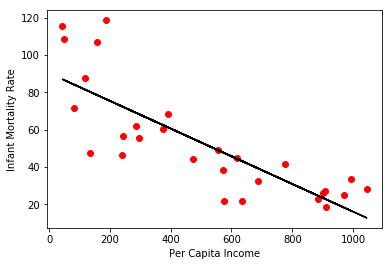

In [11]:
yhat = w[0] + w[1]*x

plt.plot(x,y,'ro')
plt.plot(x,yhat,'k-')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()


And our prediction for Hungary?

Avg RMSE:  17.386693874727353


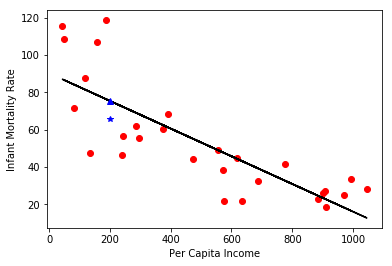

In [12]:
plt.plot(x,y,'ro')
plt.plot(x,yhat,'k-')
plt.plot(test_set['PCI'],test_set['Infant Mortality'],'b*')
plt.plot(test_set['PCI'],w[0] + w[1]*test_set['PCI'],'b^')

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))
print ("Avg RMSE: ",avg_rmse)


plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()

Not too bad!  Our prediction is much better than if we had just randomly guessed.  We can say that we have learned something.  

But can we do better with this data?  We've imposed some really strong assumptions by using a straight line as a model.  So, for this data, what happens if we select a model that has somewhat more explanatory power?

The 'linear' in linear regression doesn't actually refer to the fact that we modelled the data with a straight line.  In fact, it refers to the fact that we were able to find the minimizing parameter values through the solution of a linear set of equations (the normal equations given above).  Indeed, so long as our model is a linear combination of arbitrary functions of $x$, like
$$ w_0 + w_1 \exp (-(x-100)^2) + w_2 x^7, $$
the resulting equation to solve it is still
$$ X^T X W = X^T y, $$
where the columns of $X$ are the functions in the above expression.  These functions of $x$ are called 'basis functions', and are often denoted as $\phi_i(x)$.  For the above example, then there are three basis functions
$$ \phi_0(x)=1, \phi_1(x) = \exp(-(x-100)^2), \phi_2(x) = x^7. $$
Note that these are probably not very well selected basis functions: for real problems we will want to select them carefully (or better yet, *learn* them).

We don't need to go too crazy here.  Instead, let's consider models of the form 
$$ w_0 + w_1 x + w_2 x^2 + \ldots + w_m x^m, $$
which is to say that our function can be represented as a polynomial of degree $m$, and our basis functions are the set of monomials:
$$ \phi_i(x) = x^i, \forall i\in[1,\ldots,m]. $$
Note that because we're taking numbers to potentially high powers, we'll scale our data to the interval $[-1,1]$, just in the interests of numerical stability.  

This produces a matrix $X$ (also known as a design matrix), that looks like this:  
$$ X = 
\left[ \begin{array}{cccc} \phi_0(x_0) & \phi_1(x_0) & \cdots & \phi_m(x_0) \\ \phi_0(x_1) & \phi_1(x_1) & \cdots & \phi_m(x_1) \\ \vdots & \vdots & \ddots & \vdots \\ \phi_0(x_n) & \phi_1(x_n) & \cdots & \phi_m(x_n) \end{array} \right] =
\left[ \begin{array}{cccc} 1 & x_0 & \cdots & x_0 ^m \\ 1 & x_1 & \cdots & x_1^m \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_n & \cdots & x_n^m \end{array} \right]. $$

This matrix is also known as a Vandernonde matrix, and is common enough that numpy has a built-in function to produce it.  Let's see what happens for a quadratic polynomial (aka $m=2$): 


In [13]:
# Here's rescaling to [-1,1]
xmin = x.min()
xmax = x.max()
x = 2*(x - xmin)/(xmax-xmin) - 1
x_test = 2*(test_set['PCI'] - xmin)/(xmax-xmin) - 1


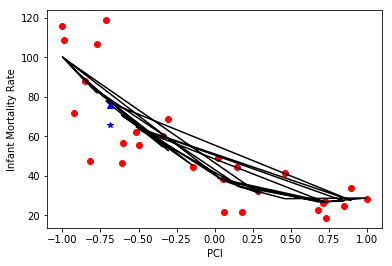

Avg. RMSE:  15.341226253666699


In [15]:
# Generate a Vandermonde matrix
degree = 2

X = np.vander(x,degree+1,increasing=True)

# Solve for the 
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

yhat = np.dot(X,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))

plt.plot(x,y,'ro')
plt.plot(x,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,w[0] + w[1]*x_test + w[2]*x_test**2,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print ("Avg. RMSE: ",avg_rmse)

Note that this looks pretty crappy in plots because the points are out of order and not smoothly varying.  Let's introduce a new variable xhat that is more densely spaced and is ordered so that we can correctly plot the curves that we produce.

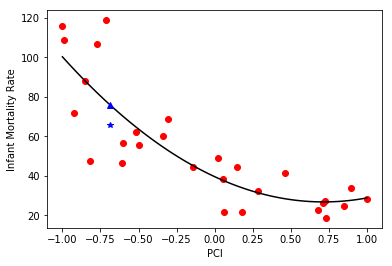

Avg. RMSE:  15.341226253666699


In [16]:
xhat = np.linspace(-1,1,101)
Xhat = np.vander(xhat,degree+1,increasing=True)

yhat = np.dot(Xhat,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,w[0] + w[1]*x_test + w[2]*x_test**2,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print ("Avg. RMSE: ",avg_rmse)

Much better.  

Note that this didn't help our predictive accuracy much for Hungary, but we can see that in general, we've reduced the misfit for all the other points.  Let's keep going by increasing the polynomial degree to 5.


15.199328076621267


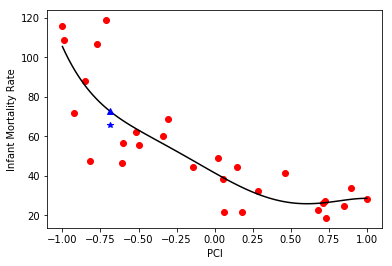

In [17]:
degree = 5

X = np.vander(x,degree+1,increasing=True)
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

Xhat = np.vander(xhat,degree+1,increasing=True)
yhat = np.dot(Xhat,w)

Xtest = np.vander([x_test],degree+1,increasing=True)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))
print (avg_rmse)

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

Same story, slightly better RMSE, not much change in prediction error for Hungary.  What if we really ramp up the model complexity

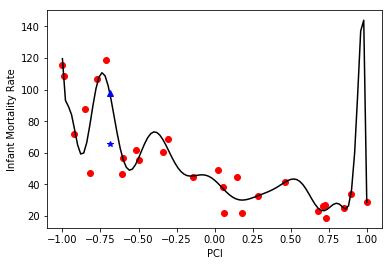

Avg. RMSE:  9.900935341671367


In [18]:
degree = 17

X = np.vander(x,degree+1,increasing=True)
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

w_unreg = w

Xhat = np.vander(xhat,degree+1,increasing=True)
yhat = np.dot(Xhat,w)

Xtest = np.vander([x_test],degree+1,increasing=True)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print ("Avg. RMSE: ",avg_rmse)

What's going on here?  Our average error in the training set is going down, but our prediction is getting worse!  The reason for this is straightforward: we're starting to fit the noise, rather than the signal.  There's a certain amount of error associated with a given label or measurement.  Some of this is from measurement error itself (Not every instance of infant mortality was counted, for example), and some of it is due to factors that we do not have any information about (perhaps a war drove up rates for a particular nation over the measurement period).  Our goal henceforth is not only to determine how to train models effectively, but also to select models in such a way that they give good predictive values for test data, rather than overfitting training data.    

One way of ensuring that we don't overfit is to carefully select our basis functions to be consistent with our a priori assumptions about the data.  This is useful in the case when we have some known physics that we're trying to find the parameters to.  For example, if we measure a series of positions for a cannonball under the influence of gravity in a vacuum in an attempt to infer the initial velocity and position, then we know that a parabola is the right shape to fit.  But we often don't know the functional relationship to start (this is a big difference between machine learning and other inverse methods).

This problem is easily solved by a complete application of Bayes' rule.  Recall that in finding our answer for the parameter values, we performed *Maximum likelihood estimation*, which is to say that we found the parameters that minimized the misfit with the data:
$$
\hat{\mathbf{w}} = \mathrm{argmax}_\mathbf{w} P(\mathbf{y}|\mathbf{x},\mathbf{w}).
$$
Note that this doesn't include any prior information about $\mathbf{w}$.  Thus $\mathbf{w}$ can take any values that it wants to.  

Instead, if we first find the complete posterior distribution on the weights and set a sensible prior, then maybe we can eliminate some of the bad behavior.  Bayes' rule tells us that 
$$
P(\mathbf{w}|\mathbf{y},\mathbf{x}) \propto P(y|\mathbf{w},\mathbf{x}) P(\mathbf{w}|\mathbf{x}).
$$
Because it's easy, let's assume that
$$
P(\mathbf{w}|\mathbf{x}) = P(\mathbf{w}) = \mathcal{N}(\mathbf{w}|0,\Sigma_w),
$$
which is to say we have a prior belief in the value of the model parameters, specifically that they are normally distributed with mean zero and a known *diagonal* covariance $\Sigma_w$.  Multiplying the prior and the likelihood together and doint some tricky linear algebra (namely an application of *completing the square*), we find that the posterior distribution of the parameters actually has a closed form solution. 
$$
P(\mathbf{w}|\mathbf{y},\mathbf{x}) = \mathcal{N}(\mathbf{w}|\mathbf{w}_{mean},\Sigma_{post}),
$$
with parameters given by 
$$
\mathbf{w}_{mean} = [X^T X + \sigma^2 \Sigma_w^{-1}]^{-1} X^T y
$$
$$
\Sigma_{post} = [\frac{X^T X}{\sigma^2} + \Sigma_w^{-1}]^{-1}.
$$

Why is this interesting?  As it turns out, you can also get these parameter values by minimizing the function
$$ \sum_{i=1}^m \frac{1}{2} [y_i - \mu(x_i)]^2 + \sum_{j=1}^n \gamma_j w_i^2 $$,
where $\gamma_i = \frac{\Sigma_{w,ii}}{\sigma^2}$.  This is exactly like the least squares function we outline above, but with an additional penalty term that makes the function that we're trying to minimize large when the parameter values get large.  Rewriting the mean in terms of gamma, we have the solution to this problem:
$$ (X^T X + \Gamma) W = X^T y, $$
where $\Gamma_{ii} = \gamma_i$ is a diagonal matrix of *regularization* paramaters.

Let's see how this influences the fit.

[[ 4.62855590e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.17595131e-01  2.56151493e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.72949156e+00  8.97805497e-02  6.42188612e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.48078855e+00 -1.80396764e+01  1.46721775e+00  1.12688526e+01
   0.00000000e+00  0.00000000e+00  0.

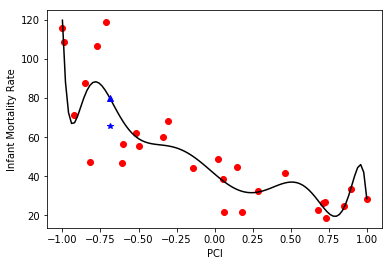

Avg. RMSE:  13.002889788238624


In [25]:
degree = 17

gamma = 1e-4
Eye = np.eye(X.shape[1])
Eye[0,0] = 0

w = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

w_small_gamma = w
Sigma_post_small_gamma = np.linalg.inv(np.dot(X.T,X) + gamma*Eye)
print(np.linalg.cholesky(Sigma_post_small_gamma))

yhat = np.dot(Xhat,w)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))
print (avg_rmse)

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print ("Avg. RMSE: ",avg_rmse)

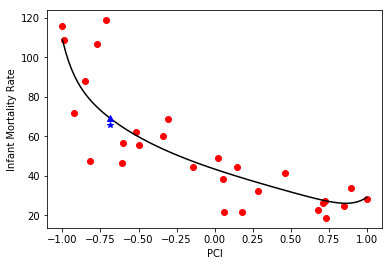

Avg. RMSE:  15.298355396674934


In [20]:
degree = 17

gamma = 1.0

w = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

w_large_gamma = w

yhat = np.dot(Xhat,w)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print ("Avg. RMSE: ",avg_rmse)

It's also fun to look at the values of the parameters themselves under different regularization choices:


[[ 8.27043838e-02  7.14338810e-03 -1.15618830e-01 -1.61652337e-03
  -2.37799742e-02 -4.95057248e-03  9.81742015e-04 -3.54020912e-03
   9.02024442e-03 -1.80009663e-03  1.14210938e-02 -5.03759530e-04
   1.17169479e-02  3.74436261e-04  1.12314325e-02  9.71132277e-04
   1.04984810e-02  1.39504842e-03]
 [ 7.14338810e-03  2.78772616e-01  6.48926966e-03 -2.65929136e-01
  -9.40135281e-03 -1.06836532e-01 -7.79306304e-03 -3.60401377e-02
  -4.19790002e-03 -9.92484858e-04 -1.60485318e-03  1.74815618e-02
  -4.02987230e-05  2.76401518e-02  8.92704691e-04  3.33953141e-02
   1.49914586e-03  3.67210416e-02]
 [-1.15618830e-01  6.48926966e-03  5.62431394e-01 -5.95931485e-03
  -2.58851666e-01 -7.65129429e-04 -1.44692239e-01  8.61033315e-04
  -7.56011265e-02  7.57414471e-04 -3.24089422e-02  8.10591046e-08
  -4.36544077e-03 -8.71378277e-04  1.44824278e-02 -1.63373600e-03
   2.75334013e-02 -2.22642161e-03]
 [-1.61652337e-03 -2.65929136e-01 -5.95931485e-03  7.46172206e-01
   6.72303095e-03 -1.81858509e-01  6.

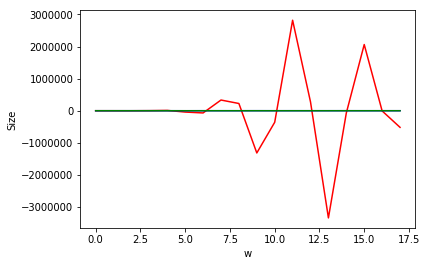

In [22]:
plt.plot(w_unreg,'r-')
plt.plot(w_small_gamma,'b-')
plt.plot(w_large_gamma,'g-')


plt.xlabel('w')
plt.ylabel('Size')
plt.show()

Or on a log scale:

In [ ]:
plt.semilogy(abs(w_unreg),'r-')
plt.semilogy(abs(w_small_gamma),'b-')
plt.semilogy(abs(w_large_gamma),'g-')
plt.xlabel('w')
plt.ylabel('Size')
plt.show()

As I mentioned above, the linear in linear regression comes from the ability to write models as linear combinations of known functions.  Just for fun, let's do this exercise for some periodic data that we'll make up.  In particular, let's look at a particularly challengin example, the sawtooth wave.    

In [ ]:
N_data = 41
x = np.linspace(-2,2,N_data)
xhat = np.linspace(-2,2,501)
y = x - np.floor(x) + np.random.randn(N_data)*0.1
plt.plot(x,y,'k.')
plt.show()

The natural set of functions for capturing a periodic function is the Fourier series.  Much like with polynomials, we need to select the complexity of our model.  As before, it's a tradeoff between overfitting and underfitting.  Let's start with the Fourier series up to their third terms.

The nice thing about design matrices is that their columns are the basis functions themselves, so we can easily plot them, just to get a sense of what we're working with before doing any fitting.

In [ ]:
degree = 3
X = np.column_stack([np.ones_like(x)]  
                  + [np.cos(N*2*np.pi*x) for N in range(1,degree+1)] 
                  + [np.sin(N*2*np.pi*x) for N in range(1,degree+1)])

Xhat = np.column_stack([np.ones_like(xhat)] + [np.cos(N*2*np.pi*xhat) for N in range(1,degree+1)] + [np.sin(N*2*np.pi*xhat) for N in range(1,degree+1)])

In [ ]:
for i in range(0,2*degree+1):
    plt.plot(xhat,Xhat[:,i],alpha=0.5)
plt.xlim(0,1)
plt.show()

The normal equations do not change.  We still have to solve
$$ (X^T X + \gamma \mathcal{I} )\mathbf{w} = X^T y $$ 
to get the optimal model parameters $\mathbf{w}$.    

In [ ]:
gamma = 1e-3
Eye = np.eye(X.shape[1])
Eye[0,0] = 0
w_0 = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

In [ ]:
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,w_0),'r-')
plt.show()

In [ ]:
degree = 8
X = np.column_stack([np.ones_like(x)]  
                  + [np.cos(N*2*np.pi*x) for N in range(1,degree+1)] 
                  + [np.sin(N*2*np.pi*x) for N in range(1,degree+1)])

Xhat = np.column_stack([np.ones_like(xhat)] + [np.cos(N*2*np.pi*xhat) for N in range(1,degree+1)] + [np.sin(N*2*np.pi*xhat) for N in range(1,degree+1)])


In [ ]:
gamma = 0
Eye = np.eye(X.shape[1])
Eye[0,0] = 0
w_1 = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,w_1),'r-')
plt.show()

In [ ]:
plt.plot(w_0)
plt.plot(w_1)
plt.show()

The 'opposite' to a global basis like the Fourier series is a local basis, which can sometimes be useful, particularly for tasks like interpolation of data that is known to have structure that isn't well captured by polynomials.  One example of such a local basis is the squared exponential radial basis function given by
$$ \phi_{rbf}(x,x_0,L) = \exp \left[-\frac{1}{2} \frac{(x-x_0)^2}{L^2} \right], $$
where we define $L$ and $x_0$ such that there is plenty of overlap.  For example

In [ ]:
x = np.random.rand(11)*2 - 1
xhat = np.linspace(-1,1,201)
y = np.sin(2*np.pi*x) + np.random.randn(11)*0.5
x_centers = np.linspace(-1,1,11)
L = 0.5*(x_centers[1]-x_centers[0])
X = np.column_stack([np.exp(-1./2.*(x-x_c)**2/(L**2)) for x_c in x_centers])
Xhat = np.column_stack([np.exp(-1./2.*(xhat-x_c)**2/(L**2)) for x_c in x_centers])

for i in range(Xhat.shape[1]):
    plt.plot(xhat,Xhat[:,i])
plt.show()


In [ ]:
plt.plot(x,y,'k.')
plt.show()

In [ ]:
gamma = 1e-3
Eye = np.eye(X.shape[1])
w = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,w),'r-')
for i in range(len(w)):
    plt.plot(xhat,Xhat[:,i]*w[i],alpha=1.0,lw=1.0)
plt.show()